# MNE-BIDS pipeline
>
#### This document will serve as a step-by-step guide to walk you through transforming your EEG dataset into one compliant with the BIDS format, using MNE-BIDS.

### What is MNE?
> MNE is an open source python package for working with EEG and MEG data, which serves to facilitate the exploration, visualisation and analysis of neuroimaging data.

### What is BIDS?
> BIDS (Brain Imaging Data Structure) is a simple method of organising neuroimaging data that is easy to adopt and promotes standardisation across neuroimaging experiments. This allows for easier, more open data sharing and collaboration.
>
> It involves a hierarchical folder organisation structure, with four main levels:
>
> ![BIDS hierarchy.png](<attachment:BIDS hierarchy.png>)
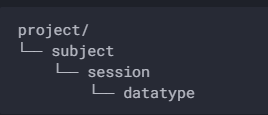

## SO, MNE-BIDS...?
> Is a processing pipeline that uses MNE-python tools to generate BIDS compliant datasets!
>
If you don't currently have MNE-BIDS installed, please refer to their official [website](https://mne.tools/mne-bids-pipeline/stable/getting_started/install.html) to do so before beginning this walkthrough.

------

# Expected Proficiencies
> #### Prior to using this pipeline, a certain level of understanding/ skill is expected. 

This entails:
- Some knowledge of python (to understand and implement the present code), although this will be explained throughout.
- An understanding of what a BIDS formatted dataset should include and how it should look (for checking the dataset has converted correctly).
  > This information can be found on the [BIDS website](https://bids.neuroimaging.io/getting_started/index.html).
- Familiarity with your EEG dataset and its associated metadata (to ensure all important information is present post-conversion and add any that is missing).

-----

# 1. Downloading data
> #### Collecting the EEG dataset necessary to run through this pipeline

In order to complete this pipeline, you will first need some EEG data. If you intend to run this pipeline using your pre-existing dataset, you can simply move onto the next step. If you don't have any EEG data to test this process on, we suggest downloading the [EEG Motor Movement/Imagery Dataset](https://physionet.org/content/eegmmidb/1.0.0/) from the [Physiobank Database](https://physionet.org/data/). 

[Link this to all of the rest of the document (edit the files to fit it in)]

GIVE LINK TO DOWNLOAD FULL CODE FROM DOC just like MNE does [At bottom]

# 2. Data formatting
> #### This pipeline's data format expectations

This pipeline is curated to work with EEGLab (brainvision and _EDF_ are recommended by MNE) [CHANGE THIS DEPENDING ON WHAT WE CHOOSE TO USE] formatted datasets, however MNE is capable of handling a variety of formats. 
>  If your data is currently in a different format, you will need to use a slightly different section of code when reading in your data (step 6). For guidance on this, refer to MNE's documentation on [importing data from EEG devices](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html#sphx-glr-auto-tutorials-io-20-reading-eeg-data-py) for guidance. 
>
The pipeline will also write the dataset into a BIDS-recommended format [EEGLab or BrainVision or EDF] in step 7. If you require a different output format, you may edit the `format` parameter of `write_raw_bids` using [MNE's guidance](https://mne.tools/mne-bids/stable/generated/mne_bids.write_raw_bids.html).

USE THE DATA FORMAT OF THE PHYSIOBANK ONE ONCE SWITCHED OVER (EDF????)

------

# 3. Importing the necessary tools
>### To begin, we will need to import all the tools necessary for converting the data.

This first section of code will import tools that allow us to work with the file paths and simplify the method of handling them.

In [ ]:
#Allows us to work with file paths
import os.path as op
#Makes file path handling simpler
from pathlib import Path

Next, we need to `import MNE`, a python package for working with EEG and MEG data, and some associated tools that we will use here. 
>
From `mne_bids`, we are importing:
- `BIDSPath`:
A tool for creating a BIDS formatted file path
- `print_dir_tree`:
A tool for presenting the contents of a folder in a 'tree' view
- `write_raw_bids`:
A tool for saving EEG data into BIDS format
>
Additionally, we wil be installing MNE-BIDS using [pip](https://pypi.org/project/pip/) (a package installer), before ensuring that MNE-BIDS is upgraded to be the newest version, to allow smooth functionality.

In [ ]:
import mne
%pip install mne_bids
%pip install --upgrade mne_bids

from mne_bids import BIDSPath, print_dir_tree, write_raw_bids, make_dataset_description, update_sidecar_json

------

# 4. Finding the data
>### After completing our imports, we need to find the EEG data files.

In the code below, the first line specifies where the folders and sub-folders for the data can be found. These should include your EEG data and any additional information (metadata). 
>
You should modify this to include your own file pathway: `data_dir = Path(r"___your file pathway____")`. This should be the file containing your task files, or the highest file level containing your dataset and no external (dataset-unrelated) files.
> Here, the `r` (raw) ensures the file location is read as is, and that the backslashes don't get interpreted as special characters, so don't break up the text.
>
The line below this prints a visualisation of the first sub-folders within (using the `print_dir_tree` tool!). 
> You may have 1 or more of these, depending on how much EEG data you wish to make BIDS compliant. Each of these should contain EEG data from one specific task type, including data from each participant and any associated metadata.

In [ ]:
#Change the file path to your data's location
data_dir = Path(r"C:\N8_internship_code\source_data")
print_dir_tree(data_dir, max_depth=1)

This next section lists the file paths for the sub-folders we just visualised and adds them to the list 'children'.

In [ ]:
children = [child for child in data_dir.iterdir()]
children

------

# 5. Selecting specific files
>### Let's specify the files we want to use

Here, the first line serves to identify which of the two files we want to write into BIDS format (note: in python, the first index is given a value of 0). If you have multiple files, each time you run through this you should change the number at the end to match the file you are wanting to adapt. 
>
The second line lists all the files in the specified subfolder.

In [ ]:
#Change this to match the file number
dir_number = 0
files = [file for file in children[dir_number].iterdir()]

This sets the first file in the folder to the variable `file_path`, then prints this. 
>
Even when completing multiple iterations (for more than one dataset), the value should NOT be changed from 0!

In [ ]:
file_path = files[0]
file_path

-------

# 6. Reading the data
>### Now we've completed our preparations, lets compile our data

Here, we are reading the EEG data from the previously selected file path to the `data` variable.
>
As previously mentioned, the current code is tailored to EEGLab formatted datasets and won't work with any other formats. As such, you must use a slightly different line of code depending on the format of your data. 

In [ ]:
data = mne.io.read_raw_eeglab(file_path)

In [ ]:
data

Here, we will specify the line frequency for the dataset, as required by BIDS. You should change the number here to reflect the line frequency of your dataset.

In [ ]:
#specify line frequency
data.info["line_freq"] = 50

How to add montage HERE

Printing `data` will display the data's information. [In what format? will it look the same as the previous table?]

This next section of code will create a new folder path for storing EEG data in BIDS format, then prints it out. 
>
We recommend renaming your file to something more specific to your dataset, by switching out the text in the quotation marks (`"bids_example"`). Attempt to avoiding using any spaces in the title to prevent possible later complications.

In [ ]:
bids_root = op.join(data_dir.parent, "bids_example")
bids_root

# 7. Writing the data
> #### Let's write our selected data into BIDS format!

First, you should manually define the partricipant number/ subject id and task name for this dataset, setting them each to a variable as seen in the first two rows.
>
Then, using the `BIDSPath` tool we imported earlier, we will assign the subject, task and the folder path we just created to `bids_path`. 
>
We will then use another imported tool, `write_raw_bids` to write the data (from the file path we defined earlier) into the new file path we created, linking it to the subject id and task type we outlined. The desired format of the output data is also outlined here `format="EEGLAB"`.

In [ ]:
#Edit this information ot match your data
subject_id = "001"
task = "rest"

bids_path = BIDSPath(subject=subject_id, task=task, root=bids_root)
write_raw_bids(data, bids_path, overwrite=True, allow_preload=True, format="EEGLAB")

_______

### Now you have formatted your dataset to BIDS standards! 
#### Don't forget to repeat steps 4 and 5 for all of the file paths we found in step 3
>
## But hold on!
#### Your BIDS formatted dataset isn't quite complete yet...

-----

# Editing and checking your BIDS formatted dataset
### The steps below will walk you through finding and editing some of the files in your new dataset, in order to make them BIDS-compliant. 
Each of these files should automatically include a large amount of information derived from your dataset and stored in BIDS format, however this may not always be completely accurate.
>
As such, the next steps will walk you through checking taht your BIDS dataset is accurate, and how to adapt these files if necessary. Some of the file's items will be deemed required for a BIDS-compliant dataset, while others are recommended or merely optional. You __MUST__ ensure that the required elements are present and have correct data, and although not necessary, it will be beneficial for you to include as much additional data as possible, especially if it is important information for your dataset.

You can do this by navigating to the file path we assigned to the variable `bids_root` in step 4, then working through all of the files and investigating what is present/correct.

----

# File 1. Sidecar
>
This file's name should have a format simlilar to *_eeg.json in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through the components it lists. Below is a list of information BIDS needs/suggests for this file. Take note of which elemets are missing/incorrect.
>
#### BIDS components:
>
Necessary:
>
    1. EEG Reference
    2. Sampling Frequency
    3. Powerline Frequency
    4. Software Filters
    5. Task Name
>
Recommended:
>
    6. Task Description
    7. Instructions
    8. CogAtlasID
    9. CogPOID
    10. Cap Manufacturer
    11. Cap Manufacturer's Model Name
    12. Software Versions
    13. Device Serial Number
    14. EEG Channel Count
    15. ECG Channel Count
    16. EMG Channel Count
    17. EOG Channel Count
    18. MISC Channel Count
    19. Trigger Channel Count
    20. Recording Duration
    21. Recording Type
    22. EpochLength
    23. EEG Ground
    24. Head Circumference
    25. EEG Placement Scheme
    26. Hardware Filters
    27. Subject Artefact Description
    28. Institution Name
    29. Institution Address
    30. Institutional Department Name
>
Optional:
>
    31. Electrical Stimulation
    32. Electrical Stimulation Parameters



## Manually updating the JSON file. 
>
To begin, you must edit the first line of code to match your file path `Path(r'___Your file path here___')`, and the second line to match your files directory `root = (r'__Your file directory here__')`. Additionally, you must change the `subject=` and `task=` sections of `bids_path1` to match your dataset's file.

Once these are re-defined, you can update specific aspects of the sidecar by editing the text in quotation marks `""` (after the colon `:`). 
>
- If the element you are editing already exists in the file, changing its associated data with the code below will change information text for that element in the file.
- If the element isn't yet present, a new element will be added below with the data you assigned to it.
- If you don't intend to include or change an item you can simply delete it from the code. 

In [ ]:
#updating a specific parameter in a JSON
json_file = Path(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_eeg.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = (r'C:\N8_internship_code\bids_example')

bids_path1 = BIDSPath(subject='001', task='rest',
                     suffix='eeg', extension='.json', datatype='eeg',
                     root=root)

entries = {'EEGReference' : "FCz",
           'SamplingFrequency': 1000.0,
           'PowerLineFrequency': 50.0,
           'SoftwareFilters': {
                "Anti-aliasing filter":{
                "half-amplitude cutoff (Hz)": 500,
                "Roll-off": "6dB/Octave"
                }
                },
            'TaskName': "Resting State",
            'TaskDescription': "Participants were asked to rest with their eyes closed for 5 minutes.",
            'Instructions': "Please close your eyes and relax. Do not think about anything in particular.",
            'CogAtlasID': "", 
            'CogPOID': "",    
            'Manufacturer': "Brain Products GmbH",
            'ManufacturersModelName':"Brain Products actiCHamp",
            'CapManufacturer': "EasyCap",
            'CapManufacturersModelName': "EasyCap 64-channel cap",
            'SoftwareVersions' : {
                'MNE-BIDS': "1.0.0",
                'MNE-Python': "1.6.1"
                },
            'DeviceSerialNumber': "123456789",
            'EEGChannelCount': 64,
            'ECGChannelCount': 2,
            'EMGChannelCount': 0,
            'EOGChannelCount': 0,
            'MiscChannelCount': 0,
            'TriggerChannelCount': 0,
            'RecordingDuration': 600,
            'RecordingType': "Continuous",
            'EpochLength': 2.0,
            'EEGGround':"Fpz", 
            'HeadCircumference': 58.0,
            'EEGPlacementScheme': "10 percent system",
            'HardwareFilters':{
               "ADC's decimation filter (hardware bandwidth limit)":{
                "-3dB cutoff point (Hz)": 480,
                "Filter order sinc response": 5
                }
                },
            'SubjectArtefactDescription': "No known artifacts were present during the recording.",
            'InstitutionName': "University of Leeds",
            'InstitutionAddress': "Leeds, UK", 
            'InstitutionalDepartmentName': "School of Psychology", 
            'ElectricalStimulation': "",
            'ElectricalStimulationParameters': "" }
           
update_sidecar_json(bids_path1, entries, verbose=True)

----

# File 2. Channels Description
>
This should have a format simlilar to *_channels.tsv in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through the components it lists. Below is a list of information BIDS needs/suggests for this file. Take note of which elemets are missing or incorrect.
>
#### BIDS components:
>
Necessary:
>
    1. Name
    2. Type
    3. Units
Recommended
>
    n/a
>
Optional:
>
    4. Description
    5. Sampling Frequency
    6. Reference
    7. Low Cutoff
    8. High Cutoff
    9. Notch
    10. Status
    11. Status Description

How to...

In [ ]:
#Channels description editing code

----

# File 3. Electrodes Description
This should have a format simlilar to *_electrodes.tsv in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through the components it lists. Below is a list of information BIDS needs/suggests for this file. Take note of which elemets are missing/incorrect.
>
#### BIDS components:
>
Necessary:
>
    1. X
    2. Y
    3. Z
>
Recommended:
>
    4. Type
    5. Material
    6. Impedance
>
Optional:
>
    n/a

How to...

In [ ]:
#Electrodes Description editing code

----

# File 4. Coordinate System
This should have a format simlilar to *_coordsystem.json in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through the components it lists. Below is a list of information BIDS needs/suggests for this file. Take note of which elemets are missing/incorrect.

#### BIDS components:
>
Necessary:
>
    1. EEG Coordinate System
    2. EEG Coordinate Units
    3. EEG Coordinate System Description
Recommended:
>
    4. Fiducials Description
    5. Fiducials Coordinates
    6. Fiducials Coordinate System
    7. Fiducials Coordinate Units
    8. Fiducials Coordinate System Description
    9. Anatomical Landmark Coordinates
    10. Anatomical Landmark Coordinate System
    11. Anatomical Landmark Coordinate Units
    12. Anatomical Landmark Coordinate System Description
>
Optional:
>
    13. Intended For

As we did with the sidecar file, the first line of code should be edited to match your file path `Path(r'___Your file path here___')`, and the second line to match your files directory `root = (r'__Your file directory here__')`. Additionally, you must change the `subject=` and `task=` sections of `bids_path1` to match your dataset's file.

Once these are redefined, you can update specific aspects of the sidecar by editing the text in quotation marks `""` (after the colon `:`). 
>
- If the element you are editing already exists in the file, changing its associated data with the code below will change information text for that element in the file.
- If the element isn't yet present, a new element will be added below with the data you assigned to it.
- If you don't intend to include or change an item you can simply delete it from the code. 

In [ ]:
#updating a specific parameter in a JSON [COORDSYSTEM]
json_file = Path(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_space-CapTrak_coordsystem.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = Path(r'C:\N8_internship_code\bids_example')


bids_path1 = BIDSPath(subject='001', task=None,
                     suffix='coordsystem', extension='.json', datatype='eeg',
                     root=json_file.parent.parent.parent)

bids_path1.update(space='CapTrak')

entries = {'EEGCoordinateSystem':"CapTrak",
           'EEGCoordinateUnits':"m",
           'EEGCoordinateSystemDescription': "CapTrak is a 3D digitization system that provides accurate spatial coordinates for EEG electrode placement.",
           'FiducialsDescription': "Fiducials are anatomical landmarks used to align the EEG cap with the participant's head. The fiducials used in this study were Nasion, Left Preauricular, and Right Preauricular.",
           'FiducialsCoordinates': {
                'Nasion': [0.0, 0.0, 0.0],
                'Left Preauricular': [-0.1, 0.0, 0.0],
                'Right Preauricular': [0.1, 0.0, 0.0]
           },
           'FiducialsCoordinateSystem': "CapTrak",
            'FiducialsCoordinateUnits': "m",
            'FiducialsCoordinateSystemDescription': "CapTrak fiducials are defined in a 3D coordinate system that aligns with the participant's head.",
            'AnatomicalLandmarkCoordinates': {
                'Nasion': [0.0, 0.0, 0.0],
                'Left Preauricular': [-0.1, 0.0, 0.0],
                'Right Preauricular': [0.1, 0.0, 0.0]
            },
            'AnatomicalLandmarkCoordinateSystem': "CapTrak",
            'AnatomicalLandmarkCoordinateUnits': "m",
            'AnatomicalLandmarkCoordinateSystemDescription': "CapTrak anatomical landmarks are defined in a 3D coordinate system that aligns with the participant's head."
            }       
update_sidecar_json(bids_path1, entries, verbose=True)

#updated in mnebids, can i change it in mne, will mne write the changes
#changing smaller sections during mne bids runthrough as opposed to editing
#change set key with set value
#example, changing single value/ nested dictionary

----

# File 5. Events
This file's name should have a format simlilar to *_events.json in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through the components it lists. Below is a list of information BIDS needs/suggests for this file. Take note of which elemets are missing/incorrect.

#### BIDS components:
>
Necessary:
>
    1. Onset
    2. Duration
>
Recommended:
>
    n/a
>
Optional:
>
    3. Trial Type
    4. Response Time
    5. HED
    6. Stim file
    7. Channel
>

Similarly to the procedure for steps 1 and 4, the first line of code should be edited to match your file path `Path(r'___Your file path here___')`, and the second line to match your files directory `root = (r'__Your file directory here__')`. Additionally, you must change the `subject=` and `task=` sections of `bids_path1` to match your dataset's file.

Once these are redefined, you can update specific aspects of the sidecar by editing the text in quotation marks `""` (after the colon `:`). 
>
- If the element you are editing already exists in the file, changing its associated data with the code below will change information text for that element in the file.
- If the element isn't yet present, a new element will be added below with the data you assigned to it.
- If you don't intend to include or change an item you can simply delete it from the code. 


In [ ]:
#Events editing code
#updating a specific parameter in a JSON
json_file = Path(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_events.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = (r'C:\N8_internship_code\bids_example')


bids_path1 = BIDSPath(subject='001', task='rest',
                     suffix='events', extension='.json', datatype='eeg',
                     root=root)

entries = {'Onset':{'Description': "Onset time of the event in seconds relative to the start of the recording.", 'Units': "seconds"},
        'Duration':{'Description': "Duration of the event in seconds.", 'Units': "Seconds"},
        'TrialType':{'LongName':"Event Category", 
                     'Description': "Indicator of the type of action that is expected.", 
                     'Levels': {
                        'Start': "A red square appears on the screen to indicate the start of a trial.",
                        'Stop': "A green square appears on the screen to indicate the end of a trial"}
                     },
        'ResponseTime':{'Description': "Time taken by the participant to respond to the event in seconds.", 'Units': "seconds"},
        'HED': {'musc': "EMG-artifact"},
        'Stim File': {'Description': "File containing the stimulus presentation information for the event.", 'FileType': "CSV", 'FilePath': "sub-001_task-rest_stim.csv"},
        'Channel': {'Description': "Channel used to record the event.", 'Type': "Trigger"}
        }       
update_sidecar_json(bids_path1, entries, verbose=True)

----

# File 6. Dataset Description
Now we can move on to the more general, yet equally as important information files. 
>
The code below will re-write the dataset description, overwriting any previous dataset description files.
This file should describe the dataset in as much detail as possible, so you should attempt to include as much of the data outlined below as possible although BIDS only requires the presence of the 'necessary' information.

#### BIDS components:
>
Necessary:
>
    1. Study Name
    2. BIDS Version 
>
Recommended:
>
    3. HED Version
    4. Dataset Type
    5. Data License
    6. Authors
    7. Generated by
        - Name
        - Version
        - Container
        - Type
        - Tag
    8. Source Datasets
>
Optional:
>
    9. Acknowledgements
    10. How to acknowledge
    11. Funding
    12. Ethics Approvals
    13. References and Links
    14 Doi
Note: `BIDS version` will be automatically included in the data file once the code is run.


Once you have decided on the information you wish to include, you can append the code below, changing the information in quotation marks to your dataset's information.
>
Any that you don't intend on including should be written as `<item>=None`, just as `acknowledgements` is below. This will skip that item, preventing its inclusion in the file. Please not that this code will overwrite any dataset description file previously generated. This can be changed by changing `overwrite=True` to `overwrite=False`. 
>
Note: Doi must be input in the format `doi:<insert_doi>`.

In [ ]:
#creating a dataset description JSON file (separate to other data entry types) [for people who want a better description of their dataset than previously provided] 
#{will overwrite any existing dataset_description.json file in the root of the BIDS directory}
make_dataset_description(
    path=bids_root,
    name="EEGManyLabs Resting State Study", 
    hed_version="1",
    dataset_type='raw',
    data_license="CCO",
    authors=["Ariana Williams", "Daniel Brady"],
    generated_by=[
        {
            "Name": "MNE-BIDS",
            "Version": "0.14",
            "Description": "Used to convert MEG data into BIDS format."
        },
        {
            "Name": "MNE-Python",
            "Version": "1.6.1",
            "Description": "Used for MEG preprocessing and analysis."
        }
    ],
    source_datasets=[
        {
            "URL": "https://example.com/source_dataset",
            "DOI": "10.1234/example.doi",
        }],
    acknowledgements=None,
    how_to_acknowledge="Cite (Williams et al., 2025) when using this dataset",
    funding=["The NHS", "The Uk government"],
    ethics_approvals="Ethical approval was granted by the University of Leeds School of Psychology Ethics committee (12345 2025)",
    references_and_links="https://mne.tools/mne-bids/stable/whats_new_previous_releases.html",
    doi="doi:https://doi.org/10.1016/j.tins.2017.02.004",
            overwrite=True,
            verbose=True)

----

# File 7. Participants.tsv

>
MNE-BIDS will automatically input the majority of this information

#### BIDS Components:
>
Necessary:
>
    1. Participant ID 
>
Recommended:
>
    2. Species
    3. Age
    4. Sex
    5. Handedness
    6. Strain
    7. Strain RRID
>
Optional:
>
    - Additional participant information may be included to further bolster your metadata.

how to...

In [ ]:
#CODE for participants.tsv

----

# File 8. Participants.json
The participants.json file exists as a counterpart to the participants.tsv file and is used to describe the TSV column names and the properties of their values, making interpretation easier, especially in the case of dataset-specific columns. 
>
MNE-BIDS will automatically input the majority of this information

#### BIDS Components:
>
Necessary:
>
    1. Participant ID 
>
Recommended:
>
    2. Species
    3. Age
    4. Sex
    5. Handedness
    6. Strain
    7. Strain RRID
>
Optional:
>
    - Additional participant information may be included to further bolster your metadata.

The code 

In [ ]:
#code for adding information to the participants.json file
json_file = Path(r'C:\N8_internship_code\bids_example\participants.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = (r'C:\N8_internship_code\bids_example')


bids_path1 = BIDSPath(subject=None, task=None,
                     suffix='participants', extension='.json', datatype=None,
                     root=root)

entries = {'Particpant ID':{'Description': "Unique Participant identifier"}, 
           'Species': {'Description': "Species of the participant"}, 
           'Age': {'Description': "Age of the participant at time of testing", 'Units': "Years"}, 
           'Sex': {'Description': "Biological sex of the participant", 
                   'Levels': {
                       "F":'Female',
                       "M":'Male'
                   }
                },
            'Handedness': {'Description': "Handedness of the participant",
                        'Levels': {
                            "R": "Right-handed",
                            "L": "Left-handed",
                            "A": "Ambidextrous"
                        }
                },
            'Strain': {'Description': "Strain of the participant, if applicable"},
            'Strain RRID': {'Description': "Strain RRI ID of the participant, if applicable"},
        }       
update_sidecar_json(bids_path1, entries, verbose=True)

#explaining how to add values and descriptions fpr extra things added to tsv file
#phenotype file

----

# 6. Adding missing *necessary* information
># Information that should be included in the BIDS configuration if you have it

In [ ]:

NOTES

#mne bids code
# Get the electrode coordinates
testing_data = mne.datasets.testing.data_path()
captrak_path = op.join(testing_data, "montage", "captrak_coords.bvct")
montage = mne.channels.read_dig_captrak(captrak_path)

# Rename the montage channel names only for this example, because as said
# before, coordinate and EEG data were not actually collected together
# Do *not* do this for your own data.
montage.rename_channels(dict(zip(montage.ch_names, raw.ch_names)))

# "attach" the electrode coordinates to the `raw` object
# Note that this only works for some channel types (EEG/sEEG/ECoG/DBS/fNIRS)
raw.set_montage(montage)

# show the electrode positions
raw.plot_sensors()

### BIDS-Required information for:
- #### Electrons description (tsv):
  - X
  - Y
  - Z
   > auto generated, uses default electrode locations, not always correct (heres how to set for a specific type montage- standardised positions (percentage gaps))
- #### Channels description (tsv):
  - Name
  - Type
  - Units
    auto
- #### Events (tsv):
  - Onset
  - Duration
    >events auto, descriptions need to be manually added after (.json) (this is auto generated but blank)
- #### Coordinates System (JSON):
  - EEG Coordinate System
  - EEG Coordinate Units
  - EEG Coordinate System Description
- #### Sidecar (JSON):
  - EEG Reference
    - `mne.set_eeg_reference()` // `raw.set_eeg_reference()`
    > may/may not be set or may need to be set through software [highlight branching paths]
  - Sampling Frequency
    >automatically produced during conversion
  - Powerline Frequency
    >manually needs setting
    >##### specify power line frequency as required by BIDS
    raw.info["line_freq"] = 60
    raw_er.info["line_freq"] = 60

  - Software Filters
  - Task Name

`mne.io.Raw.set_montage()` = electrode locations and head shapes for EEG recordings
https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html#sphx-glr-auto-tutorials-io-20-reading-eeg-data-py
__Both of these are uncertain, need to check them in an actual coding setting__


https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_eeg_reference

https://mne.tools/stable/help/migrating.html - some more commands?

add to files after, set in code, manual
ideally as much as possible will be done in code, but some may need to be done in files manually

In [ ]:

NOTES

Let’s pause and check that the information that we’ve written out to the sidecar files that describe our data is correct.
# Get the sidecar ``.json`` file
sidecar_json_bids_path = bids_path.copy().update(suffix="meg", extension=".json")
sidecar_json_content = sidecar_json_bids_path.fpath.read_text(encoding="utf-8-sig")
print(sidecar_json_content)

----

# 7. Adding missing *recommended* information
>### Information that isn't required to add, but is often useful to include

### BIDS-recommended information for:
- #### Electrons description (tsv):
  - __~Type~__
  - __~Material~__
  - __~Impedance~__
_are these still required bits of info?_
- #### Sidecar (JSON):
  - Cap Manufacturer
  - Cap Manufacturer's Model Name
  - EEG Channel Count
  - ECG Channel Count
  - EMG Channel Count
  - EOG Channel Count
  - MISC Channel Count
  - Trigger Channel Count
  - Recording Duration
  - Recording Type
  - __~EpochLength~__
  - EEG Ground
  - Head Circumference
  - EEG Placement Scheme
  - Hardware Filters
  - Subject Artefact Description
  - Task Description
  - Instructions
  - __~CogAtlasID~__
  - __~CogPOID~__
  - Institution Name
  - Institution Address
  - Institutional Department Name

can link to mne doc or say cant be added and will be added manually

-----

# 8. Adding missing *optional* information 
>### information that isn't at all necessary to add, but may be useful for your particular dataset

### BIDS-Optional information:
- #### Electrons description (tsv):
 ???
- #### Channels description (tsv):
  - Description
  - Sampling Frequency
  - Reference
  - Low Cutoff
  - High Cutoff
  - Notch
  - Status
  - Status Description
- #### Events (tsv):
  - __~TrialType~__
  - __~ResponseTime~__
  - __~HED~__
  - __~StimFile~__
  - __~Channel~__
- #### Sidecar (JSON):
  - Electrical Stimulation
  - Electrical Stimulation Parameters

# Citations
MNE-BIDS
> Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software, 4:1896. DOI: 10.21105/joss.01896
>
>  Pernet, C.R., Appelhoff, S., Gorgolewski, K.J. et al. EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Sci Data 6, 103 (2019). https://doi.org/10.1038/s41597-019-0104-8
>
MNE-Python
> Alexandre Gramfort, Martin Luessi, Eric Larson, Denis A. Engemann, Daniel Strohmeier, Christian Brodbeck, Roman Goj, Mainak Jas, Teon Brooks, Lauri Parkkonen, and Matti S. Hämäläinen. MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7(267):1–13, 2013. doi:10.3389/fnins.2013.00267.
>
BIDS
> Gorgolewski, K.J., Auer, T., Calhoun, V.D., Craddock, R.C., Das, S., Duff, E.P., Flandin, G., Ghosh, S.S., Glatard, T., Halchenko, Y.O., Handwerker, D.A., Hanke, M., Keator, D., Li, X., Michael, Z., Maumet, C., Nichols, B.N., Nichols, T.E., Pellman, J., Poline, J.-B., Rokem, A., Schaefer, G., Sochat, V., Triplett, W., Turner, J.A., Varoquaux, G., Poldrack, R.A. (2016). The brain imaging data structure, a format for organizing and describing outputs of neuroimaging experiments. Scientific Data, 3 (160044). doi:10.1038/sdata.2016.44
>
>  Pernet, C. R., Appelhoff, S., Gorgolewski, K.J., Flandin, G., Phillips, C., Delorme, A., Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific data, 6 (103). doi:10.1038/s41597-019-0104-8

# how you should cite MNE-BIDS (look at their pipeline)

In [ ]:
readme = op.join(bids_root, "README")
with open(readme, encoding="utf-8-sig") as fid:
    text = fid.read()
print(text)